In [3]:
import spheroidal
from spheroidal import *

from importlib import reload

In [4]:
reload(spheroidal)
from spheroidal import *

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
header = ['m', 'l', 'l_p', 'n_p', 'p1r',  'p2r',  'p3r',  'p4r',  'p1i', 
          'p2i',  'p3i',  'p4i',  'sr',  'si',  'mr',  'mi']

In [7]:
with open("./data/swsh_fits.dat", 'r') as f:
    df_ssm = pd.read_csv(f, header = None, sep = "\s+")

In [8]:
df_ssm.columns = header

In [33]:
def ssmc(l, m, l_p, n_p, a):
    row = df_ssm[(df_ssm['m'] == m) & (df_ssm['l'] == l) & (df_ssm['l_p'] == l_p) & (df_ssm['n_p'] == n_p)]
    p1r = row['p1r'].values[0]
    p2r = row['p2r'].values[0]
    p3r = row['p3r'].values[0]
    p4r = row['p4r'].values[0]
    p1i = row['p1i'].values[0]
    p2i = row['p2i'].values[0]
    p3i = row['p3i'].values[0]
    p4i = row['p4i'].values[0]
    if l == l_p:
        delta_llp = 1
    else:
        delta_llp = 0
    mu_re = delta_llp + p1r * a**p2r + p3r * a**p4r
    mu_im = p1i * a**p2i + p3i * a**p4i
    return mu_re + 1.j*mu_im

def ssmc_ratio(l, m, l_p, n_p, a):
    mu_mix = ssmc(l, m, l_p, n_p, a)
    mu_org = ssmc(l_p, m, l_p, n_p, a)
    return mu_mix / mu_org

In [100]:
def mode_in_df(df, SXS_num, l, m, mode_string):
    row = df[(df['SXS_num'] == SXS_num) & (df['l'] == l) & (df['m'] == m) & (df['mode_string'] == mode_string)]
    return len(row) > 0

def mode_in_df_num(df_num, l, m, mode_string):
    row = df_num[(df_num['l'] == l) & (df_num['m'] == m) & (df_num['mode_string'] == mode_string)]
    return len(row) > 0

In [110]:
def mixing_check_SXS_nums(df, l, m, l_p, n_p):
    mix_check_num = []
    SXS_num_arr = df.SXS_num.unique()
    for SXS_num in SXS_num_arr:
        df_num = df_in[df_in['SXS_num'] == SXS_num]
        retro = df_num['retro'].values[0]
        if retro:
            m_mode = -m
        else:
            m_mode = m
        mix_exist = mode_in_df_num(df_num, l, m, f'{l_p}.{m_mode}.{n_p}')
        org_exist = mode_in_df_num(df_num, l_p, m, f'{l_p}.{m_mode}.{n_p}')
        if mix_exist and org_exist:
            mix_check_num.append(SXS_num)
    return mix_check_num

In [135]:
df_in = pd.read_csv("./pickle/data_frame/run5.csv")

In [136]:
l, m = 2, 2
l_p = 3
n_p = 0
mix_check_num = mixing_check_SXS_nums(df_in, l, m, l_p, n_p)

In [154]:
ratio_err_list = []
chi_list = []
for SXS_num in mix_check_num:
    df_num = df_in[df_in['SXS_num'] == SXS_num]
    chi_rem = df_num['chi_rem'].values[0]
    chi_list.append(chi_rem)
    A_ratio, phi_diff = give_mixing_ratio(df_num, l, m, l_p, n_p)
    mu = ssmc_ratio(l, m, l_p, n_p, chi_rem)
    muabs = np.abs(mu)
    ratio_err = np.abs((A_ratio - muabs)/muabs)
    ratio_err_list.append(ratio_err)

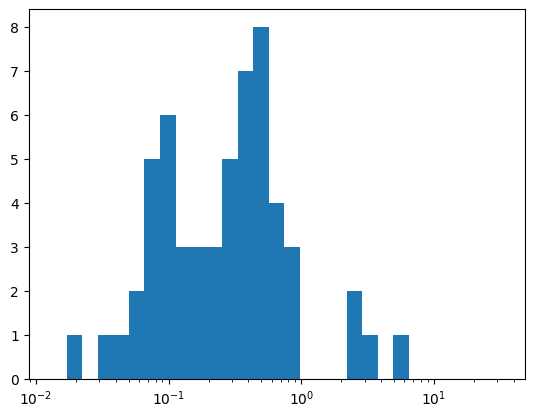

In [155]:
logbins = np.logspace(np.log10(min(ratio_err_list)),np.log10(max(ratio_err_list)),30)
plt.hist(ratio_err_list, bins = logbins)
plt.xscale('log')

In [158]:
list(zip(mix_check_num, chi_list, ratio_err_list))

[(1419, 0.276295259740119, 0.15907823801518517),
 (1420, 0.2656155671839721, 0.11204247326050458),
 (1421, 0.1170984739305816, 0.260531310009404),
 (1422, 0.2720616910587081, 0.08442795993538536),
 (1423, 0.1328560347897942, 0.5247372080358943),
 (1424, 0.0929269104313671, 0.3839996990304328),
 (1425, 0.1513412224217628, 0.05363926428689859),
 (1426, 0.6504424728460807, 0.3542359367760319),
 (1427, 0.1107143851327306, 0.15177728577879934),
 (1429, 0.1669394390986847, 0.6838106618899976),
 (1430, 0.5040032667632252, 0.08958313181496173),
 (1431, 0.3577685057476598, 0.22848014805146802),
 (1432, 0.7918172613975334, 0.5047055515201216),
 (1433, 0.2238943944740042, 0.35412362685231835),
 (1435, 0.1828164270319105, 0.5360881098760372),
 (1436, 0.3607908010741281, 0.38969717774079765),
 (1442, 0.1304088351422976, 0.44423185962078715),
 (1443, 0.6308987934797512, 0.25468769161475463),
 (1444, 0.3269654569176105, 0.3835621831070526),
 (1445, 0.1576790375861976, 0.23453923472960905),
 (1446, 0.

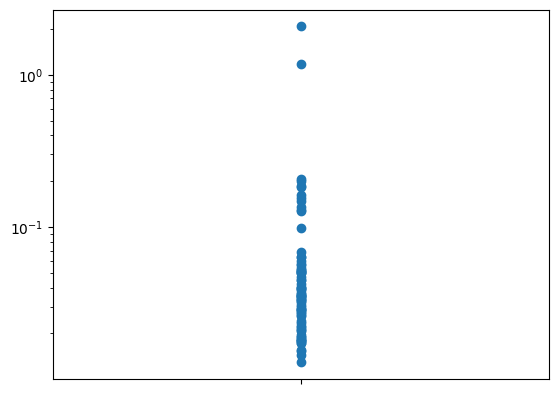

In [124]:
plt.scatter(['']*len(ratio_err_list), ratio_err_list)
plt.yscale('log')

In [152]:
SXS_num = 1462
df_num = df_in[df_in['SXS_num'] == SXS_num]
df_num

,Unnamed: 0,SXS_num,M_rem,chi_rem,chi_1_z,chi_2_z,q,l,m,retro,mode_string,A_med,A_hi,A_low,phi_med,phi_hi,phi_low
1180,0,1462,0.976084,0.261979,-0.799917,0.510739,2.631195,2,2,False,2.2.0,7.280678e-01,7.281514e-01,7.280342e-01,1.810683,1.811196,1.810529
1181,0,1462,0.976084,0.261979,-0.799917,0.510739,2.631195,2,2,False,3.2.0,2.607537e-03,2.886931e-03,2.587318e-03,-7.677496,-7.496126,-7.796607
1182,0,1462,0.976084,0.261979,-0.799917,0.510739,2.631195,2,2,False,constant,1.949014e-05,1.954056e-05,1.939189e-05,2.096600,2.104288,2.090202
1183,0,1462,0.976084,0.261979,-0.799917,0.510739,2.631195,2,2,False,2.-2.0,9.802224e-04,1.042161e-03,9.224980e-04,11.148928,11.245694,11.125264
1184,0,1462,0.976084,0.261979,-0.799917,0.510739,2.631195,2,2,False,2.2.1,1.838148e+00,1.863595e+00,1.794474e+00,-1.967833,-1.943999,-2.109207
1185,0,1462,0.976084,0.261979,-0.799917,0.510739,2.631195,2,1,False,2.1.0,2.918998e-01,2.965917e-01,2.905034e-01,-2.858125,-2.826928,-2.889025
1186,0,1462,0.976084,0.261979,-0.799917,0.510739,2.631195,2,1,False,constant,1.040422e-05,1.164168e-05,8.414716e-06,-2.793168,-0.850458,-3.942621
1187,0,1462,0.976084,0.261979,-0.799917,0.510739,2.631195,3,3,False,3.3.0,1.617121e-01,1.630996e-01,1.581168e-01,-0.226889,-0.222713,-0.249433
1188,0,1462,0.976084,0.261979,-0.799917,0.510739,2.631195,3,3,False,constant,1.574567e-06,2.759432e-06,8.656500e-07,18.840912,21.265338,16.823563
1189,0,1462,0.976084,0.261979,-0.799917,0.510739,2.631195,4,4,False,constant,6.830598e-07,1.060646e-06,2.872004e-07,22.446153,22.877170,21.602754


In [82]:
M_rem = df_num['M_rem'].values[0]
chi_rem = df_num['chi_rem'].values[0]

In [83]:
# primed mode mixing into un_primed harmonic
def give_mixing_ratio(df_num, l, m, l_p, n_p):
    retro = df_num['retro'].values[0]
    if retro:
        m_mode = -m
    else:
        m_mode = m
    row_mix = df_num[(df_num['l'] == l) & (df_num['m'] == m) & (df_num['mode_string'] == f'{l_p}.{m_mode}.{n_p}')]
    row_org = df_num[(df_num['l'] == l_p) & (df_num['m'] == m) & (df_num['mode_string'] == f'{l_p}.{m_mode}.{n_p}')]
    A_mix = row_mix['A_med'].values[0]
    A_org = row_org['A_med'].values[0]
    phi_mix = row_mix['phi_med'].values[0]%(2*np.pi)
    phi_org = row_org['phi_med'].values[0]%(2*np.pi)
    return A_mix / A_org, phi_mix - phi_org

In [84]:
l, m = 3, 2
l_p = 2
n_p = 0
A_ratio, phi_diff = give_mixing_ratio(df_num, l, m, l_p, n_p)
print(A_ratio, phi_diff)

0.00896732637935888 3.1979784015908983


In [85]:
mu = ssmc_ratio(l, m, l_p, n_p, chi_rem)
print(np.abs(mu))
print(np.angle(mu))

0.010619903713367197
-2.8914136687292142


In [86]:
mu

(-0.010289286194498858-0.002629247894148742j)

In [87]:
df_num

,Unnamed: 0,SXS_num,M_rem,chi_rem,chi_1_z,chi_2_z,q,l,m,retro,mode_string,A_med,A_hi,A_low,phi_med,phi_hi,phi_low
181,0,1425,0.989989,0.151341,-0.800021,0.672689,6.118067,2,2,True,2.-2.1,9.157668e-01,9.464284e-01,8.607698e-01,-3.138052,-3.021254,-3.227906
182,0,1425,0.989989,0.151341,-0.800021,0.672689,6.118067,2,2,True,2.2.0,3.950266e-03,4.002331e-03,3.863480e-03,4.865163,4.879110,4.854244
183,0,1425,0.989989,0.151341,-0.800021,0.672689,6.118067,2,2,True,3.-2.0,8.673717e-04,9.015203e-04,7.254024e-04,0.889034,0.947291,0.814833
184,0,1425,0.989989,0.151341,-0.800021,0.672689,6.118067,2,2,True,2.-2.0,4.250458e-01,4.251203e-01,4.249572e-01,0.411150,0.411637,0.411067
185,0,1425,0.989989,0.151341,-0.800021,0.672689,6.118067,2,2,True,constant,1.060784e-05,1.062158e-05,1.045379e-05,8.264002,8.271562,8.248707
186,0,1425,0.989989,0.151341,-0.800021,0.672689,6.118067,2,1,True,2.-1.0,2.378773e-01,2.583367e-01,2.197495e-01,-3.547339,-3.439511,-3.636973
187,0,1425,0.989989,0.151341,-0.800021,0.672689,6.118067,3,3,True,constant,1.233637e-06,1.423525e-06,8.148544e-07,9.986852,10.347167,9.473670
188,0,1425,0.989989,0.151341,-0.800021,0.672689,6.118067,3,3,True,3.-3.0,1.364896e-01,1.373940e-01,1.362727e-01,-2.480408,-2.475512,-2.488427
189,0,1425,0.989989,0.151341,-0.800021,0.672689,6.118067,3,3,True,4.-3.0,8.759284e-04,1.027864e-03,5.945187e-04,-14.745340,-13.422625,-16.400136
190,0,1425,0.989989,0.151341,-0.800021,0.672689,6.118067,4,4,True,5.-4.0,3.336471e-02,3.344450e-02,3.323895e-02,-11.898100,-10.978932,-12.812765
